# Analysis of the Distribution and Variation of Temperatures in the Contiguous 48 States
Jessica Embury

# NOAA DATA COLLECTION & PROCESSING

In [ ]:
#import modules
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
from shapely.geometry import Point

#modules for visualization
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import geoplot

### USER ENTERED VARIABLES FOR PROGRAM:

In [3]:
#NOAA token to retrieve data during request
token = {'token': ''}

In [19]:
#variables to set parameters for data retrieval from NOAA
#required parameters
datasetid = 'GSOY'
startdate = '1999-01-01' #YYYY-MM-DD
enddate = '2016-12-31' #YYYY-MM-DD

#optional parameters
datatypeid = ['DX70','DX90','EMXT','TAVG','TMAX'] #['TMAX', 'TAVG', 'EMXT', 'DX90', 'DX70'] #None #[] list object containing strings
locationid = ['US'] #San Diego County:['06073'] #None #[] list object containing strings
stationid = None #[] list object containing strings
units = 'standard' #None #'' #string type: standard or metric
sortfield = None #'' #string type: id, name, mindate, maxdate, datacoverage
sortorder = None #'' #string type: asc or desc
limit = 1000 #None #int type: max 1000, default 25
includemetadata = None #Boolean type: True(default) or False

In [20]:
#specify paths out for exported csv files of temp and station data
weather_csv_out = 'output/gsoy_csv_files/gsoy_temps1.csv'
station_csv_out = 'output/gsoy_stns.csv'

In [6]:
#specify epsg code as a 4 digit integer for creation of geodataframe
epsg_code = 4269 #NAD83 = 4269, WGS84 = 4326

#specify path for exported point shapefile containing noaa data
shapefile_out_path = 'output/shapefiles/gsoy_temps.shp'

### FUNCTIONS FOR USE IN PROGRAM:
create_parameter_string, get_weather_data, get_station_data, create_gdf, combine_csv

In [8]:
#function to create query parameter string from user entered parameters
def create_parameter_string(datasetid, startdate, enddate, datatypeid = None, locationid = None, stationid = None, units = None, sortfield = None, sortorder = None, limit = None, includemetadata = None):
    """
    Method to create query parameter string from user entered parameters
    Returns parameter string.
    """
    #FORMAT OPTIONAL PARAMETERS FOR USE IN QUERY'S PARAMETER STRING
    #optional data param names to be stored in list
    data_params = []

    #format all values from datatypeid list and add to optional parameters list
    if(datatypeid != None):
        dtid_param = '&datatypeid='
        for i in range(len(datatypeid)):
            if(i==0):
                dtid = str(datatypeid[i])
                dtid_param += dtid
            else:
                dtid = '&datatypeid='+ str(datatypeid[i])
                dtid_param += dtid
        data_params.append(dtid_param)
    #print(dtid_param)           

    #format all values from locationid list and add to optional parameters list
    if(locationid != None):
        lid_param = '&locationid='
        for i in range(len(locationid)):
            if(i==0):
                lid = 'FIPS:' + str(locationid[i])
                lid_param += lid
            else:
                lid = '&locationid=FIPS:' + str(locationid[i])
                lid_param += lid
        data_params.append(lid_param)
    #print(lid_param)

    #format all values from stationid list and add to optional parameters list
    if(stationid != None):
        sid_param = '&stationid='
        for i in range(len(stationid)):
            if(i==0):
                sid = 'GHCND:' + str(stationid[i])
                sid_param += sid
            else:
                sid = '&stationid=GHCND:' + str(stationid[i])
                sid_param += sid
        data_params.append(sid_param)
    #print(sid_param)

    #format units and add to optional parameters list
    if(units != None):
        u_param = '&units='+ str(units)
        data_params.append(u_param)
    #print(u_param)

    #format sortfield and add to optional parameters list
    if(sortfield != None):
        sf_param = '&sortfield='+ str(sortfield)
        data_params.append(sf_param)
    #print(sf_param)

    #format sortorder and add to optional parameters list
    if(sortorder != None):
        so_param = '&sortorder='+ str(sortorder)
        data_params.append(so_param)
    #print(so_param)

    #format limit and add to optional parameters list
    if(limit != None):
        lim_param = '&limit='+ str(limit)
        data_params.append(lim_param)
    #print(lim_param)
    
    #format includemetadata and add to optional parameters list
    if(includemetadata != None):
        md_param = '&includemetadata='+ str(includemetadata)
        data_params.append(md_param)
    #print(md_param)
    

    #CREATE PARAMETER STRING VARIABLE; FORMAT AND ADD INFO FOR REQUIRED PARAMETERS
    params = 'datasetid='+str(datasetid)+'&'+ 'startdate='+str(startdate)+'&'+'enddate='+str(enddate)#+'&offset=126000'

    
    #ADD FORMATTED OPTIONAL PARAMETERS TO PARAMETER STRING
    #loop through optional_params, add items to params statement if value != None
    for i in range(len(data_params)):
        params += str(data_params[i])
    print(params)
    
    #return parameter string
    return params

In [9]:
#Function to retrieve weather data using NOAA web services API
def get_weather_data(token, params, base_url_data='https://www.ncdc.noaa.gov/cdo-web/api/v2/data', limit=25):
    """
    Method to retrieve weather data using NOAA web services API.
    NOAA API limit default is set to 25.
    Parses results and creates pandas dataframe object.
    Returns dataframe with weather data.
    """
    #import modules
    import os
    import pandas as pd
    import requests
    import sys
    
    #data request
    r = requests.get(base_url_data, params = params, headers=token)

    #print status of request
    print("Request status code: "+str(r.status_code))
    
    #parse json results, create pandas dataframe object
    df = pd.DataFrame.from_dict(r.json()['results'])
    
    #return pandas dataframe with weather data
    return df

In [10]:
#Function to retrieve spatial station data using NOAA web services API
def get_station_data(token, params, base_url_stations='https://www.ncdc.noaa.gov/cdo-web/api/v2/stations', limit=25):
    """
    Method to retrieve spatial station data using NOAA web services API.
    NOAA API limit default is set to 25.
    Will iterate and use limit/offset to retrieve all data.
    Parses results and creates pandas dataframe object.
    Returns dataframe with station data.
    """
    #import modules
    import os
    import pandas as pd
    import requests
    import sys
    
    
    #data request
    r = requests.get(base_url_stations, headers = token, params=param_str)
    print("Request status code: "+str(r.status_code))
    
    #parse json results, create pandas dataframe object
    df_stations= pd.DataFrame.from_dict(r.json()['results'])
    
    #if 1000 items retrieved, check for more stations
    offset = 0
    while(len(df_stations)% limit == 0):
        #set offset for iteration
        offset += limit
    
        #add offset parameter to params string
        params_offset = params + '&offset=' + str(offset) 
    
        #request stations
        r = requests.get(base_url_stations, params = params_offset, headers=token)
    
        #print status of request
        print("Request status code: "+str(r.status_code))
    
        #parse this iteration's results, put in stations dataframe
        df_temp = pd.DataFrame.from_dict(r.json()['results'])
    
        #append temp dataframe to original stations dataframe
        df_stations = df_stations.append(df_temp)
    
    #print df_stations length
    print('df_stations length: {}'.format(len(df_stations)))
    
    #return pandas dataframe containing spatial station data
    return df_stations

In [11]:
#FUNCTION TO CREATE GEODATAFRAME OF SORTED, MERGED DATA
def create_gdf(df, epsg_code):
    """        
    Geodataframe created using Shapely geometry.
    
    Returns the geodataframe.
    """
    #import modules
    import geopandas as gpd 
    import pandas as pd
    from shapely.geometry import Point
    
    #Create a GeoDataFrame
    #create an empty geometry list object
    geometry = []
    
    #iterate to fill geometry list with station points
    for i, row in df.iterrows():
        x = row['longitude']
        y = row['latitude']
        geometry.append(Point((x,y)))

    #specify the coordinate system
    crs = {'init': 'epsg:{}'.format(epsg_code)}

    #create a GeoDataFrame object 
    gdf = gpd.GeoDataFrame(df, crs = crs, geometry = geometry)
    
    return gdf

In [12]:
def combine_csv(directory_path, combo_csv_path):
    """
    Function to read and concatenate all csv files in a folder into a combined csv file
    
        directory_path: sets the directory from which to read csv files
    
        combo_csv_path: name.csv for output data
    
    Returns panda dataframe
    """
    import os 
    import glob
    import pandas as pd

    #specify path for input files
    os.chdir(directory_path)
    
    #specify file extension
    ext = 'csv'
    
    #add all csv filenames in folder to list
    filenames = [i for i in glob.glob('*.{}'.format(ext))]
    print(filenames)
    
    #combine csv files
    df = pd.concat([pd.read_csv(f) for f in filenames])

    #export new combined csv file
    df.to_csv(combo_csv_path, index = False)
    
    #return panda dataframe
    return df

### WEATHER DATA SETUP, RETRIEVAL, CSV FILE EXPORT:

In [21]:
#Create parameter string for use in NOAA query 
param_str = create_parameter_string(datasetid, startdate, enddate, datatypeid=datatypeid, locationid=locationid, units = units, limit = limit)

datasetid=GSOY&startdate=2011-01-01&enddate=2016-12-31&datatypeid=DX70&datatypeid=DX90&datatypeid=EMXT&datatypeid=TAVG&datatypeid=TMAX&locationid=FIPS:US&units=standard&limit=1000


In [22]:
#Get first round of data, create dataframe
weather_df = get_weather_data(token = token, params = param_str, limit = limit)

print(len(weather_df))
weather_df.head()

Request status code: 200
1000


,attributes,datatype,date,station,value
0,X,DX70,2011-01-01T00:00:00,GHCND:AQW00061705,365.0
1,X,DX90,2011-01-01T00:00:00,GHCND:AQW00061705,1.0
2,"X,0414,",EMXT,2011-01-01T00:00:00,GHCND:AQW00061705,90.0
3,X,TAVG,2011-01-01T00:00:00,GHCND:AQW00061705,81.2
4,X,TMAX,2011-01-01T00:00:00,GHCND:AQW00061705,86.0


In [23]:
#iterate to get all data (if limit = items retrieved during last request)
offset = 0
while(len(weather_df) % limit == 0):
    
    #set offset for next iteration
    offset += limit
    
    #add/modify offset parameter to params string for all subsequent requests
    params_offset = param_str + '&offset=' + str(offset) 
    
    temp_df = get_weather_data(token = token, params = params_offset, limit = limit)
        
    #append temp dataframe to original dataframe
    weather_df = weather_df.append(temp_df)
    
    print('weather_df length:{}'.format(len(weather_df)))

Request status code: 200
weather_df length:2000
Request status code: 200
weather_df length:3000
Request status code: 200
weather_df length:4000
Request status code: 200
weather_df length:5000
Request status code: 200
weather_df length:6000
Request status code: 200
weather_df length:7000
Request status code: 200
weather_df length:8000
Request status code: 200
weather_df length:9000
Request status code: 200
weather_df length:10000
Request status code: 200
weather_df length:11000
Request status code: 200
weather_df length:12000
Request status code: 200
weather_df length:13000
Request status code: 200
weather_df length:14000
Request status code: 200
weather_df length:15000
Request status code: 200
weather_df length:16000
Request status code: 200
weather_df length:17000
Request status code: 200
weather_df length:18000
Request status code: 200
weather_df length:19000
Request status code: 200
weather_df length:20000
Request status code: 200
weather_df length:21000
Request status code: 200
wea

Request status code: 200
weather_df length:168000
Request status code: 200
weather_df length:169000
Request status code: 200
weather_df length:170000
Request status code: 200
weather_df length:171000
Request status code: 200
weather_df length:172000
Request status code: 200
weather_df length:173000
Request status code: 200
weather_df length:174000
Request status code: 200
weather_df length:175000
Request status code: 200
weather_df length:176000
Request status code: 200
weather_df length:177000
Request status code: 200
weather_df length:178000
Request status code: 200
weather_df length:179000
Request status code: 200
weather_df length:180000
Request status code: 200
weather_df length:181000
Request status code: 200
weather_df length:182000
Request status code: 200
weather_df length:183000
Request status code: 200
weather_df length:184000
Request status code: 200
weather_df length:185000
Request status code: 200
weather_df length:186000
Request status code: 200
weather_df length:187000


In [24]:
print(len(weather_df))
weather_df.tail()

189831


,attributes,datatype,date,station,value
826,W,DX70,2016-01-01T00:00:00,GHCND:VQW00011624,366.0
827,W,DX90,2016-01-01T00:00:00,GHCND:VQW00011624,89.0
828,"W,0830,",EMXT,2016-01-01T00:00:00,GHCND:VQW00011624,94.0
829,W,TAVG,2016-01-01T00:00:00,GHCND:VQW00011624,81.5
830,W,TMAX,2016-01-01T00:00:00,GHCND:VQW00011624,87.5


In [ ]:
#rename value to reflect nature of data
#weather_df = weather_df.rename(columns = {'value':'max_temp'})

#delete redundant datatype column
#del weather_df['datatype']
#del weather_df['Unnamed: 0']


In [ ]:
#check weather_df prior to exporting as a csv file
weather_df.head()

In [25]:
#export raw weather data as csv file
weather_csv = weather_df.to_csv(weather_csv_out)

### RETRIEVE SPATIAL STATION DATA:

In [26]:
#request station data, methods iterates to get all stations
station_df = get_station_data(token = token, params = param_str, limit = limit)

Request status code: 200
Request status code: 200
Request status code: 200
Request status code: 200
Request status code: 200
Request status code: 200
Request status code: 200
Request status code: 200
Request status code: 200
df_stations length: 8869


### FORMAT, EXPORT STATION DATA:

In [27]:
#rename station id column to match weather dataframe
station_df = station_df.rename(columns = {'id':'station'})

#subset data to eliminate unnecessary columns
station_df = station_df[['station','latitude','longitude','name']]

print(len(station_df))
station_df.head()

8869


,station,latitude,longitude,name
0,GHCND:AQW00061705,-14.33056,-170.71361,"PAGO PAGO WEATHER SERVICE OFFICE AIRPORT, US"
1,GHCND:CA001018611,48.03330,-123.33330,"VICTORIA GONZALES CS, WA US"
2,GHCND:CA001135126,49.00000,-118.76670,"MIDWAY, WA US"
3,GHCND:CA005020881,49.00000,-97.23330,"EMERSON AUTO, ND US"
4,GHCND:CA006020559,48.63330,-93.96670,"BARWICK, MN US"


In [28]:
#export station data as csv file
stn_csv = station_df.to_csv(station_csv_out)

### FORMAT WEATHER DATA, PERFORM CALCULATIONS:

In [29]:
#combine multiple weather data csv files into one pandas dataframe

#set paths
directory_path = 'output/gsoy_csv_files'
combo_csv_path = 'output/gsoy_csv_files/gsoy_temps_all.csv'

#call method to combine weather data csv files
weather_df = combine_csv(directory_path, combo_csv_path)

['gsoy_temps1.csv', 'gsoy_temps2.csv', 'gsoy_temps3.csv', 'gsoy_temps4.csv']


In [30]:
#check to make sure no duplicates in the csv files

print(len(weather_df))

#drop any duplicate values
weather_df = weather_df.drop_duplicates(keep='first', inplace=False)

print(len(weather_df))

524123
524123


### FORMAT DATA BY STATION FOR USE IN GEODATAFRAME:

In [32]:
weather_df.head()

,Unnamed: 0,attributes,datatype,date,station,value
0,0,0,DX70,1999-01-01T00:00:00,GHCND:AQW00061705,365.0
1,1,0,DX90,1999-01-01T00:00:00,GHCND:AQW00061705,35.0
2,2,"0,1225,",EMXT,1999-01-01T00:00:00,GHCND:AQW00061705,93.0
3,3,0,TAVG,1999-01-01T00:00:00,GHCND:AQW00061705,81.6
4,4,0,TMAX,1999-01-01T00:00:00,GHCND:AQW00061705,86.8


In [33]:
del weather_df['Unnamed: 0']
del weather_df['attributes']

weather_df.head()

,datatype,date,station,value
0,DX70,1999-01-01T00:00:00,GHCND:AQW00061705,365.0
1,DX90,1999-01-01T00:00:00,GHCND:AQW00061705,35.0
2,EMXT,1999-01-01T00:00:00,GHCND:AQW00061705,93.0
3,TAVG,1999-01-01T00:00:00,GHCND:AQW00061705,81.6
4,TMAX,1999-01-01T00:00:00,GHCND:AQW00061705,86.8


In [34]:
#create weather df with one row for each station
noaa_df = weather_df['station'].drop_duplicates(keep='first', inplace=False).reset_index()
del noaa_df['index']

print(len(noaa_df))
noaa_df.head()

9974


,station
0,GHCND:AQW00061705
1,GHCND:CA001018611
2,GHCND:CA001135126
3,GHCND:CA004038116
4,GHCND:CA004038740


In [39]:
#calculate total days about 90 degrees F for each station
#sum DX90 for each station

dx90= weather_df.query('datatype == "DX90"')
dx90 = dx90.rename(columns = {'value': 'DX90'})
del dx90['datatype']

dx90 = dx90[['DX90','station']].groupby('station').sum().reset_index()

print(len(dx90))
dx90.head()

9974


,station,DX90
0,GHCND:AQW00061705,774.0
1,GHCND:CA001018611,8.0
2,GHCND:CA001135126,385.0
3,GHCND:CA004038116,103.0
4,GHCND:CA004038740,31.0


In [40]:
#Merge number of days with 90+ degree max temp to new station dataframe
noaa_df = noaa_df.merge(dx90, on='station')
noaa_df.head()

In [42]:
#calculate total days about 70 degrees F for each station
#sum DX70 for each station

dx70= weather_df.query('datatype == "DX70"')
dx70 = dx70.rename(columns = {'value': 'DX70'})
del dx70['datatype']

dx70 = dx70[['DX70','station']].groupby('station').sum().reset_index()

print(len(dx70))
dx70.head()

9974


,station,DX70
0,GHCND:AQW00061705,6575.0
1,GHCND:CA001018611,600.0
2,GHCND:CA001135126,2004.0
3,GHCND:CA004038116,845.0
4,GHCND:CA004038740,283.0


In [43]:
#Merge number of days with 70+ degree max temp to new station dataframe
noaa_df = noaa_df.merge(dx70, on='station')
noaa_df.head()

,station,DX90,DX70
0,GHCND:AQW00061705,774.0,6575.0
1,GHCND:CA001018611,8.0,600.0
2,GHCND:CA001135126,385.0,2004.0
3,GHCND:CA004038116,103.0,845.0
4,GHCND:CA004038740,31.0,283.0


In [44]:
#calculate extreme max temp for each station
#max EMXT for each station

emxt = weather_df.query('datatype == "EMXT"')
emxt = emxt.rename(columns = {'value': 'EMXT'})
del emxt['datatype']

emxt = emxt[['EMXT','station']].groupby('station').max().reset_index()

print(len(emxt))
emxt.head()

9974


,station,EMXT
0,GHCND:AQW00061705,95.0
1,GHCND:CA001018611,96.0
2,GHCND:CA001135126,105.0
3,GHCND:CA004038116,103.0
4,GHCND:CA004038740,99.0


In [45]:
#Merge extreme max temp to new station dataframe
noaa_df = noaa_df.merge(emxt, on='station')
noaa_df.head()

,station,DX90,DX70,EMXT
0,GHCND:AQW00061705,774.0,6575.0,95.0
1,GHCND:CA001018611,8.0,600.0,96.0
2,GHCND:CA001135126,385.0,2004.0,105.0
3,GHCND:CA004038116,103.0,845.0,103.0
4,GHCND:CA004038740,31.0,283.0,99.0


In [46]:
#calculate average max daily temp for each station
#mean TMAX for each station

tmax = weather_df.query('datatype == "TMAX"')
tmax = tmax.rename(columns = {'value': 'TMAX'})
del tmax['datatype']

tmax = tmax[['TMAX','station']].groupby('station').mean().reset_index()

print(len(tmax))
tmax.head()

9974


,station,TMAX
0,GHCND:AQW00061705,86.655556
1,GHCND:CA001018611,56.894118
2,GHCND:CA001135126,58.718750
3,GHCND:CA004038116,52.766667
4,GHCND:CA004038740,52.600000


In [47]:
#Merge average max temp to new station dataframe
noaa_df = noaa_df.merge(tmax, on='station')
noaa_df.head()

,station,DX90,DX70,EMXT,TMAX
0,GHCND:AQW00061705,774.0,6575.0,95.0,86.655556
1,GHCND:CA001018611,8.0,600.0,96.0,56.894118
2,GHCND:CA001135126,385.0,2004.0,105.0,58.718750
3,GHCND:CA004038116,103.0,845.0,103.0,52.766667
4,GHCND:CA004038740,31.0,283.0,99.0,52.600000


In [48]:
#calculate overall mean temp for each station
#mean TAVG for each station

tavg = weather_df.query('datatype == "TAVG"')
tavg = tavg.rename(columns = {'value': 'TAVG'})
del tavg['datatype']

tavg = tavg[['TAVG','station']].groupby('station').mean().reset_index()

print(len(tavg))
tavg.head()

9861


,station,TAVG
0,GHCND:AQW00061705,82.233333
1,GHCND:CA001018611,51.100000
2,GHCND:CA001135126,46.050000
3,GHCND:CA004038116,40.588889
4,GHCND:CA004038740,39.500000


In [49]:
#Merge average temp to new station dataframe
noaa_df = noaa_df.merge(tavg, on='station')
noaa_df.head()

,station,DX90,DX70,EMXT,TMAX,TAVG
0,GHCND:AQW00061705,774.0,6575.0,95.0,86.655556,82.233333
1,GHCND:CA001018611,8.0,600.0,96.0,56.894118,51.100000
2,GHCND:CA001135126,385.0,2004.0,105.0,58.718750,46.050000
3,GHCND:CA004038116,103.0,845.0,103.0,52.766667,40.588889
4,GHCND:CA004038740,31.0,283.0,99.0,52.600000,39.500000


In [50]:
#check noaa_df prior to merging with station_df
print(len(noaa_df))
noaa_df.head()

9861


,station,DX90,DX70,EMXT,TMAX,TAVG
0,GHCND:AQW00061705,774.0,6575.0,95.0,86.655556,82.233333
1,GHCND:CA001018611,8.0,600.0,96.0,56.894118,51.100000
2,GHCND:CA001135126,385.0,2004.0,105.0,58.718750,46.050000
3,GHCND:CA004038116,103.0,845.0,103.0,52.766667,40.588889
4,GHCND:CA004038740,31.0,283.0,99.0,52.600000,39.500000


### MERGE DATAFRAMES, CREATE GEODATAFRAME, AND EXPORT SHAPEFILE:

In [1]:
#merge noaa_df and station_df

#import csv files, read as dataframes if needed prior to merge
import pandas as pd
station_df = pd.read_csv('output/gsoy_stns.csv')
weather_df = pd.read_csv('output/gsoy_csv_files/gsoy_temps_all.csv')

print(len(station_df))
station_df.head()

print(len(weather_df))
weather_df.head()

7706
691637


,Unnamed: 0,attributes,date,station,max_temp
0,0,",,W,0700",2019-06-21T00:00:00,GHCND:AQW00061705,85.0
1,1,",,C,",2019-06-21T00:00:00,GHCND:CA001018611,64.0
2,2,",,C,",2019-06-21T00:00:00,GHCND:CA001135126,77.0
3,3,",,C,",2019-06-21T00:00:00,GHCND:CA005020881,73.0
4,4,",,C,",2019-06-21T00:00:00,GHCND:CA006020559,77.0


In [ ]:
#merge weather_df with station_df
noaa_df = noaa_df.merge(station_df, on='station')
noaa_df.head()

In [52]:
#create geodataframe
noaa_gdf = create_gdf(noaa_df, epsg_code)
noaa_gdf.head()

,station,DX90,DX70,EMXT,TMAX,TAVG,latitude,longitude,name,geometry
0,GHCND:AQW00061705,774.0,6575.0,95.0,86.655556,82.233333,-14.33056,-170.71361,"PAGO PAGO WEATHER SERVICE OFFICE AIRPORT, US",POINT (-170.71361 -14.33056)
1,GHCND:CA001018611,8.0,600.0,96.0,56.894118,51.100000,48.03330,-123.33330,"VICTORIA GONZALES CS, WA US",POINT (-123.3333 48.0333)
2,GHCND:CA001135126,385.0,2004.0,105.0,58.718750,46.050000,49.00000,-118.76670,"MIDWAY, WA US",POINT (-118.7667 49)
3,GHCND:CA006020559,20.0,941.0,97.0,49.540000,39.430000,48.63330,-93.96670,"BARWICK, MN US",POINT (-93.9667 48.6333)
4,GHCND:CQC00914080,0.0,2175.0,89.0,83.350000,78.933333,15.21361,145.74972,"CAPITOL HILL 1, US",POINT (145.74972 15.21361)


In [ ]:
#exports noaa_gdf as an ESRI shapefile
noaa48_gdf.to_file(driver = "ESRI Shapefile", filename = shapefile_out_path)

### KEEP ONLY DATA FOR THE 48 CONTIGUOUS STATES:

In [56]:
#create bounding box for contiguous 48 states
geometry = [Polygon([[-128,22],[-128,52],[-65,52],[-65,22]])]
crs = {'init':'epsg:4269'}

bbox_gdf = gpd.GeoDataFrame(crs = crs, geometry = geometry)
bbox_gdf

,geometry
0,"POLYGON ((-128 22, -128 52, -65 52, -65 22, -1..."


In [57]:
#keep only stations that are within 48 contiguous states (bounding box)
noaa48_gdf = gpd.sjoin(noaa_gdf, bbox_gdf, op='within')

print(len(noaa48_gdf))
noaa48_gdf.head()

8200


,station,DX90,DX70,EMXT,TMAX,TAVG,latitude,longitude,name,geometry,index_right
1,GHCND:CA001018611,8.0,600.0,96.0,56.894118,51.100000,48.0333,-123.3333,"VICTORIA GONZALES CS, WA US",POINT (-123.3333 48.0333),0
2,GHCND:CA001135126,385.0,2004.0,105.0,58.718750,46.050000,49.0000,-118.7667,"MIDWAY, WA US",POINT (-118.7667 49),0
3,GHCND:CA006020559,20.0,941.0,97.0,49.540000,39.430000,48.6333,-93.9667,"BARWICK, MN US",POINT (-93.9667 48.6333),0
17,GHCND:USC00010160,972.0,3380.0,105.0,75.100000,62.821429,32.9452,-85.9480,"ALEXANDER CITY, AL US",POINT (-85.94799999999999 32.9452),0
18,GHCND:USC00010390,834.0,3486.0,104.0,72.181250,61.540000,34.7752,-86.9508,"ATHENS, AL US",POINT (-86.9508 34.7752),0


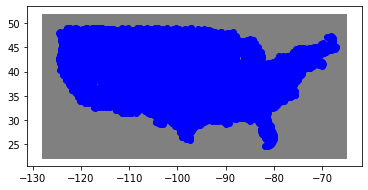

In [58]:
#plot noaa48_gdf points
fig, ax = plt.subplots()
bbox_gdf.plot(ax=ax, color='gray')
noaa48_gdf.plot(ax=ax, color='blue')
plt.show()

In [59]:
#exports noaa_gdf as an ESRI shapefile
noaa48_gdf.to_file(driver = "ESRI Shapefile", filename = shapefile_out_path)